# Task 2

---

## Predictive modeling of customer bookings

In [155]:
# !pip install -U numpy
# !pip install -U xgboost
# !pip install shap

# !pip install --user xgboost

  Using cached shap-0.41.0-cp39-cp39-win_amd64.whl (435 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
pyldavis 3.4.0 requires numpy>=1.22.0, but you have numpy 1.20.3 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached numpy-1.20.3-cp39-cp39-win_amd64.whl (13.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2


In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import OrdinalEncoder
import pickle
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score
from scipy.stats import randint
from sklearn.tree import plot_tree

from sklearn.inspection import permutation_importance
# import shap

import xgboost as xgb

from xgboost import XGBClassifier

# from sklearn.tree import export_graphviz
# from IPython.display import Image
# import graphviz

In [158]:
xgb.__version__

'1.7.5'

In [3]:
## Read the dataset

df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.tail()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0
49999,1,Internet,RoundTrip,19,6,10,Thu,PERPNH,Australia,0,1,0,5.62,0


In [4]:
## Check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
## Import GDP data

df_gdp = pd.read_csv('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_5358417.csv', encoding="ISO-8859-1", skiprows=4)

df_gdp = df_gdp[['Country Name', '2021']]
df_gdp = df_gdp.rename(columns={'Country Name': 'booking_origin', '2021': 'gdp_per_capita'})
df_gdp.head()

,booking_origin,gdp_per_capita
0,Aruba,29342.100858
1,Africa Eastern and Southern,1549.772730
2,Afghanistan,368.754614
3,Africa Western and Central,1757.030626
4,Angola,1953.533757


In [6]:
## Merge main data frame with GDP per capita data to check which country has different name with the GDP data

df_temp = pd.merge(df, df_gdp, on='booking_origin', how='left')

## Identify the country mismatch. These are country names that are has null GDP per capita in the main data frame

df_temp[df_temp['gdp_per_capita'].isna()]['booking_origin'].unique()

array(['South Korea', 'Czech Republic', 'Slovakia', 'Réunion',
       '(not set)', 'Hong Kong', 'Laos', 'Turkey', 'Taiwan', 'Brunei',
       'Iran', 'Russia', 'Kuwait', 'Macau', 'Myanmar (Burma)',
       'Norfolk Island', 'Egypt', 'Gibraltar', 'Svalbard & Jan Mayen'],
      dtype=object)

In [7]:
# df_gdp['booking_origin'].unique()

In [8]:
## Search for country names in the GDP data frame that have null values in the main data frame

search = ['Slo', 'union', 'Tai', 'Chi', 'Kuwait', 'Norfolk', 'Gibraltar', 'Svalbard']
df_gdp[df_gdp['booking_origin'].str.contains('|'.join(search))]

,booking_origin,gdp_per_capita
39,Chile,16265.095977
40,China,12556.333120
84,Gibraltar,NaN
96,"Hong Kong SAR, China",49800.542414
127,Kuwait,NaN
146,"Macao SAR, China",43873.591164
221,Slovak Republic,21391.925334
222,Slovenia,29291.400623


In [9]:
## Replacing the names in the GDP data frame that are different from the main data frame. We use name in the main data frame.

replace_dictionary = {'Korea, Rep.':'South Korea',
                      'Russian Federation':'Russia',
                      'Hong Kong SAR, China':'Hong Kong',
                      'Iran, Islamic Rep.':'Iran',
                      'Brunei Darussalam':'Brunei',
                      'Egypt, Arab Rep.':'Egypt',
                      'Lao PDR':'Laos',
                      'Macao SAR, China':'Macau',
                      'Turkiye':'Turkey',
                      'Czechia':'Czech Republic',
                      'Slovak Republic':'Slovakia'
                      }

df_gdp['booking_origin'] = df_gdp['booking_origin'].replace(replace_dictionary)

## The name for Myanmar in the main data frame is Myanmar (Burma), we change it to just Myanmar

df['booking_origin'] = df['booking_origin'].replace({'Myanmar (Burma)':'Myanmar'})

df_gdp

,booking_origin,gdp_per_capita
0,Aruba,29342.100858
1,Africa Eastern and Southern,1549.772730
2,Afghanistan,368.754614
3,Africa Western and Central,1757.030626
4,Angola,1953.533757
...,...,...
261,Kosovo,5269.783901
262,"Yemen, Rep.",NaN
263,South Africa,7055.044776
264,Zambia,1137.343633


In [10]:
## Now we do real merge. Not a temp data frame. Then we check if there are still null values.

df = pd.merge(df, df_gdp, on='booking_origin', how='left')

df[df['gdp_per_capita'].isna()]['booking_origin'].unique()

array(['Réunion', '(not set)', 'Taiwan', 'Kuwait', 'Norfolk Island',
       'Czechia', 'Gibraltar', 'Svalbard & Jan Mayen'], dtype=object)

In [11]:
## Check for null values

df.isna().sum()

num_passengers              0
sales_channel               0
trip_type                   0
purchase_lead               0
length_of_stay              0
flight_hour                 0
flight_day                  0
route                       0
booking_origin              0
wants_extra_baggage         0
wants_preferred_seat        0
wants_in_flight_meals       0
flight_duration             0
booking_complete            0
gdp_per_capita           2186
dtype: int64

In [12]:
## Check where the gdp_per_capita is still null

df[df['gdp_per_capita'].isna()]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,gdp_per_capita
221,2,Internet,RoundTrip,92,65,13,Mon,AKLKUL,Réunion,1,0,0,8.83,0,NaN
252,2,Internet,RoundTrip,14,17,10,Sat,AKLKUL,(not set),1,0,0,8.83,1,NaN
1147,3,Internet,RoundTrip,40,17,0,Fri,AKLKUL,(not set),0,0,0,8.83,0,NaN
1190,2,Internet,RoundTrip,49,261,13,Sun,AKLKUL,Réunion,0,0,0,8.83,0,NaN
1208,1,Internet,RoundTrip,307,32,15,Thu,AKLKUL,Réunion,1,0,1,8.83,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49939,1,Mobile,RoundTrip,216,6,10,Thu,PENTPE,Taiwan,1,0,0,4.67,0,NaN
49961,1,Internet,RoundTrip,30,6,7,Thu,PENTPE,Taiwan,0,0,0,4.67,0,NaN
49968,1,Internet,RoundTrip,25,6,12,Fri,PENTPE,Taiwan,0,0,0,4.67,1,NaN
49972,1,Internet,RoundTrip,33,6,6,Wed,PENTPE,Taiwan,1,1,0,4.67,1,NaN


C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='booking_origin', ylabel='count'>

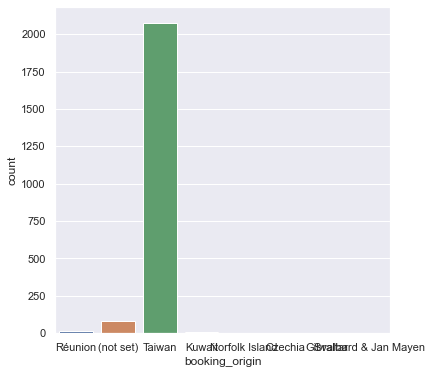

In [13]:
## Check where the gdp_per_capita is still null

sns.set(rc={'figure.figsize':(6, 6)})
sns.countplot(df[df['gdp_per_capita'].isna()]['booking_origin'])

In [14]:
## Taiwan's GDP per capita is 4693
## Taiwan's GDP per capita is still null. It has a lot of rows so we just input it manually


df.loc[df['booking_origin']=='Taiwan', 'gdp_per_capita'] = 4693
df.loc[df['booking_origin']=='Kuwait', 'gdp_per_capita'] = 24300.33


In [15]:
df.isna().sum()

num_passengers             0
sales_channel              0
trip_type                  0
purchase_lead              0
length_of_stay             0
flight_hour                0
flight_day                 0
route                      0
booking_origin             0
wants_extra_baggage        0
wants_preferred_seat       0
wants_in_flight_meals      0
flight_duration            0
booking_complete           0
gdp_per_capita           100
dtype: int64

In [16]:
## Remove rows with null values

df = df.dropna()
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
gdp_per_capita           0
dtype: int64

In [17]:
## Check basic statistics

df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,gdp_per_capita
count,49900.000000,49900.000000,49900.000000,49900.000000,49900.000000,49900.000000,49900.000000,49900.000000,49900.000000,49900.000000
mean,1.590922,84.949178,23.046613,9.066693,0.668918,0.297014,0.427214,7.278384,0.149559,35745.985173
std,1.019996,90.489476,33.884673,5.409765,0.470607,0.456947,0.494679,1.496649,0.356642,23803.906167
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.670000,0.000000,368.754614
25%,1.000000,21.000000,5.000000,5.000000,0.000000,0.000000,0.000000,5.620000,0.000000,11109.261839
50%,1.000000,51.000000,17.000000,9.000000,1.000000,0.000000,0.000000,7.570000,0.000000,39312.660373
75%,2.000000,115.000000,28.000000,13.000000,1.000000,1.000000,1.000000,8.830000,0.000000,60443.109165
max,9.000000,867.000000,778.000000,23.000000,1.000000,1.000000,1.000000,9.500000,1.000000,100172.079253


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49900 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49900 non-null  int64  
 1   sales_channel          49900 non-null  object 
 2   trip_type              49900 non-null  object 
 3   purchase_lead          49900 non-null  int64  
 4   length_of_stay         49900 non-null  int64  
 5   flight_hour            49900 non-null  int64  
 6   flight_day             49900 non-null  object 
 7   route                  49900 non-null  object 
 8   booking_origin         49900 non-null  object 
 9   wants_extra_baggage    49900 non-null  int64  
 10  wants_preferred_seat   49900 non-null  int64  
 11  wants_in_flight_meals  49900 non-null  int64  
 12  flight_duration        49900 non-null  float64
 13  booking_complete       49900 non-null  int64  
 14  gdp_per_capita         49900 non-null  float64
dtypes:

In [19]:
## Convert data type of multiple columns

columns_to_convert = ['purchase_lead', 'flight_hour', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete']
df[columns_to_convert] = df[columns_to_convert].astype('str')
df['purchase_lead'] = df['purchase_lead'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49900 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49900 non-null  int64  
 1   sales_channel          49900 non-null  object 
 2   trip_type              49900 non-null  object 
 3   purchase_lead          49900 non-null  int32  
 4   length_of_stay         49900 non-null  int64  
 5   flight_hour            49900 non-null  object 
 6   flight_day             49900 non-null  object 
 7   route                  49900 non-null  object 
 8   booking_origin         49900 non-null  object 
 9   wants_extra_baggage    49900 non-null  object 
 10  wants_preferred_seat   49900 non-null  object 
 11  wants_in_flight_meals  49900 non-null  object 
 12  flight_duration        49900 non-null  float64
 13  booking_complete       49900 non-null  object 
 14  gdp_per_capita         49900 non-null  float64
dtypes:

In [20]:
## Count null values in each column

df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
gdp_per_capita           0
dtype: int64

In [21]:
## Import public holiday of countries data

df_holiday = pd.read_csv('List_of_countries_by_number_of_public_holidays_1.csv')

df_holiday = df_holiday.rename(columns={'Number of public holidays':'number_of_holidays', 'Country':'booking_origin'})
df_holiday

,booking_origin,number_of_holidays
0,Argentina,19
1,Australia,11
2,Austria,14
3,Bangladesh,22
4,Belgium,10
...,...,...
72,United Kingdom,9
73,United States,11
74,Uruguay,12
75,Venezuela,14


In [22]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   booking_origin      77 non-null     object
 1   number_of_holidays  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [23]:
## Merge main data frame with number of holidays data to check which country has different name

df = pd.merge(df, df_holiday, on='booking_origin', how='left')

## Identify the country mismatch.

df[df['number_of_holidays'].isna()]['booking_origin'].unique()

array(['China', 'Czech Republic', 'Vietnam', 'United Arab Emirates',
       'Tonga', 'Saudi Arabia', 'Qatar', 'Laos', 'Oman', 'Kenya',
       'Brunei', 'Bahrain', 'Solomon Islands', 'Mauritius', 'Kuwait',
       'Jordan', 'Timor-Leste', 'New Caledonia', 'Macau', 'Panama',
       'Bhutan', 'Nicaragua', 'Maldives', 'Tunisia', 'Papua New Guinea',
       'Paraguay', 'Seychelles', 'Afghanistan', 'Guam', 'Malta',
       'Vanuatu', 'Belarus', 'Iraq', 'Ghana', 'Guatemala', 'Algeria'],
      dtype=object)

In [24]:
df.isna().sum()

num_passengers              0
sales_channel               0
trip_type                   0
purchase_lead               0
length_of_stay              0
flight_hour                 0
flight_day                  0
route                       0
booking_origin              0
wants_extra_baggage         0
wants_preferred_seat        0
wants_in_flight_meals       0
flight_duration             0
booking_complete            0
gdp_per_capita              0
number_of_holidays       4480
dtype: int64

In [25]:
df['number_of_holidays'].unique()

array(['12', '21', '9', nan, '14', '16', '19', '11', '15', '10', '17',
       '18', '25', '13', '22', '26', '35', '8', '32'], dtype=object)

In [26]:
df[df['number_of_holidays'].isna()]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,gdp_per_capita,number_of_holidays
19,1,Internet,RoundTrip,351,17,3,Sun,AKLHGH,China,0,0,0,5.07,0,12556.333120,NaN
126,2,Internet,RoundTrip,140,18,7,Sun,AKLKUL,China,1,0,0,8.83,0,12556.333120,NaN
129,1,Internet,RoundTrip,285,30,12,Wed,AKLKUL,Czech Republic,1,1,1,8.83,0,26821.245228,NaN
138,2,Internet,RoundTrip,82,25,18,Fri,AKLKUL,Czech Republic,1,0,0,8.83,0,26821.245228,NaN
157,1,Internet,RoundTrip,182,28,10,Sun,AKLKUL,Vietnam,0,0,1,8.83,0,3756.489121,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49582,2,Internet,RoundTrip,7,6,7,Tue,PENPVG,China,1,0,0,5.33,0,12556.333120,NaN
49587,1,Mobile,RoundTrip,14,6,12,Wed,PENPVG,China,0,1,0,5.33,0,12556.333120,NaN
49590,7,Internet,RoundTrip,91,6,13,Wed,PENPVG,China,0,0,0,5.33,0,12556.333120,NaN
49591,1,Internet,RoundTrip,55,6,5,Thu,PENPVG,China,0,0,0,5.33,0,12556.333120,NaN


In [27]:
df_holiday['booking_origin'].unique()

array(['Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium',
       'Barbados', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile',
       'Colombia', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Fiji',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Ireland', 'Israel',
       'Italy', 'Japan', 'Kazakhstan', 'Kosovo', 'Latvia', 'Lebanon',
       'Liechtenstein', 'Lithuania', 'Malaysia', 'Mexico', 'Mongolia',
       'Myanmar', 'Nepal', 'Netherlands', 'New Zealand', 'Norway',
       'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'Russia', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia',
       'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'Tanzania',
       'Trinidad and Tobago', 'Turkey', 'Ukraine', 'United Kingdom',
       'United States', 'Uruguay', 'Venezuela

<AxesSubplot:xlabel='count', ylabel='booking_origin'>

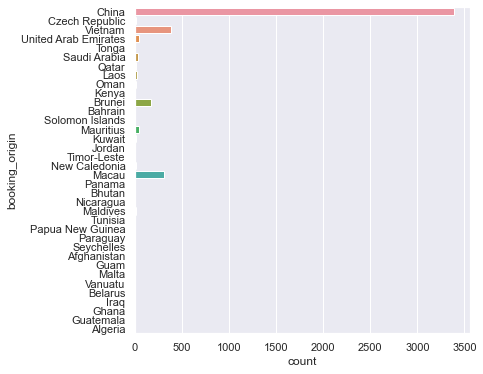

In [28]:
sns.set(rc={'figure.figsize':(6, 6)})
sns.countplot(y=df[df['number_of_holidays'].isna()]['booking_origin'])

In [29]:
## Fill the null values in the public holiday column with mean values

df['number_of_holidays'] = pd.to_numeric(df['number_of_holidays'])
df['number_of_holidays'] = df['number_of_holidays'].fillna(df['number_of_holidays'].mean(skipna=True))
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
gdp_per_capita           0
number_of_holidays       0
dtype: int64

In [30]:
## Copy data frame in case something broken along the way

df_copy = df.copy()

In [31]:
## Split the route column into start route and end route
df['route_start'] = df['route'].str[:3]
df['route_end'] = df['route'].str[-3:]

df = df.drop(columns='route')

df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,gdp_per_capita,number_of_holidays,route_start,route_end
0,2,Internet,RoundTrip,262,19,7,Sat,New Zealand,1,0,0,5.52,0,48781.026633,12.0,AKL,DEL
1,1,Internet,RoundTrip,112,20,3,Sat,New Zealand,0,0,0,5.52,0,48781.026633,12.0,AKL,DEL
2,2,Internet,RoundTrip,243,22,17,Wed,India,1,1,0,5.52,0,2256.590409,21.0,AKL,DEL
3,1,Internet,RoundTrip,96,31,4,Sat,New Zealand,0,0,1,5.52,0,48781.026633,12.0,AKL,DEL
4,2,Internet,RoundTrip,68,22,15,Wed,India,1,0,1,5.52,0,2256.590409,21.0,AKL,DEL


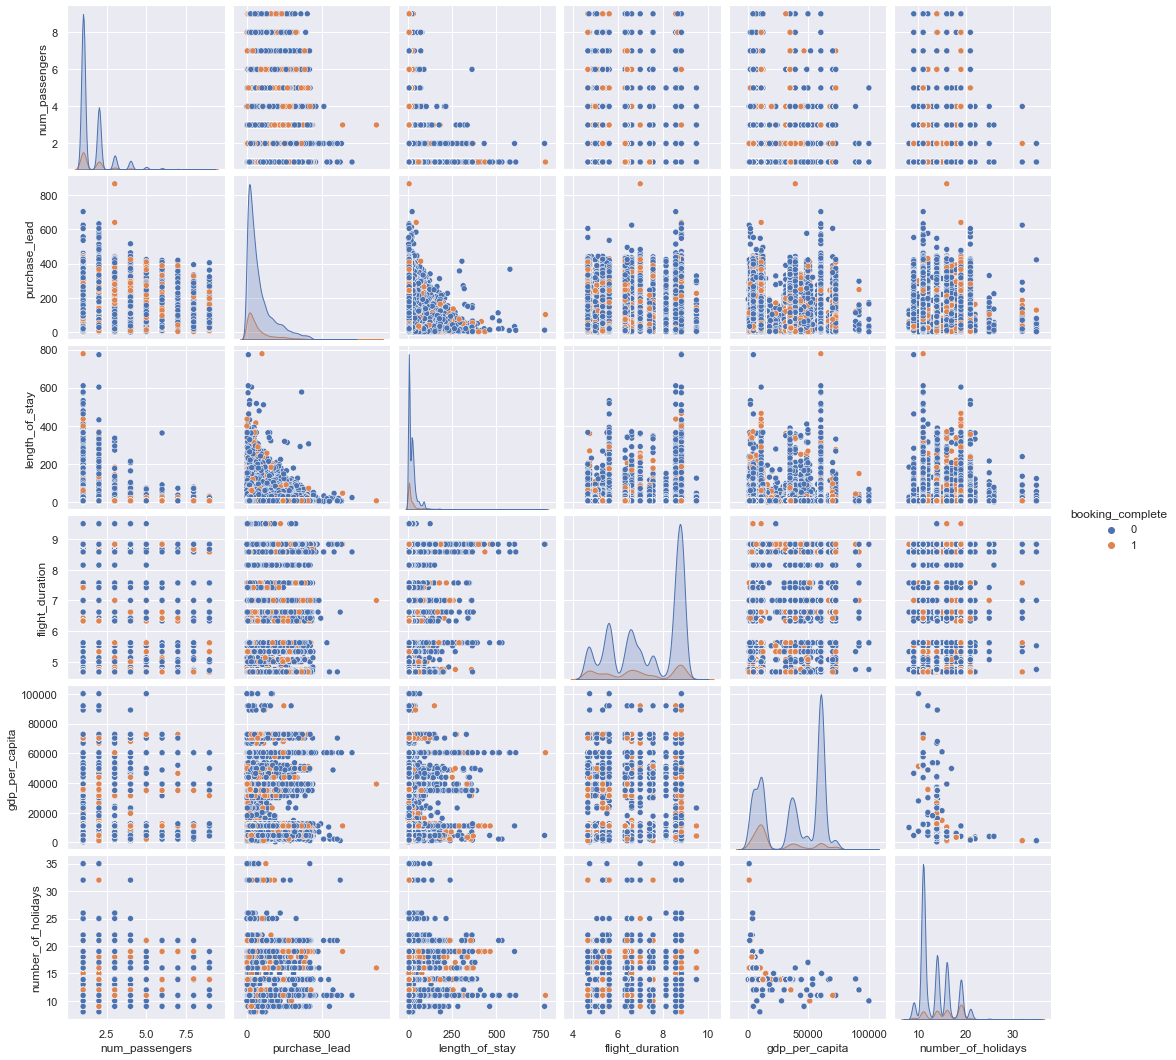

In [32]:
## Create pairplot on numeric columns

df_numeric = df[['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_duration', 'gdp_per_capita', 'booking_complete', 'number_of_holidays']]

sns.set(rc={'figure.figsize':(12, 12)})
sns.pairplot(df_numeric, hue='booking_complete')

<AxesSubplot:>

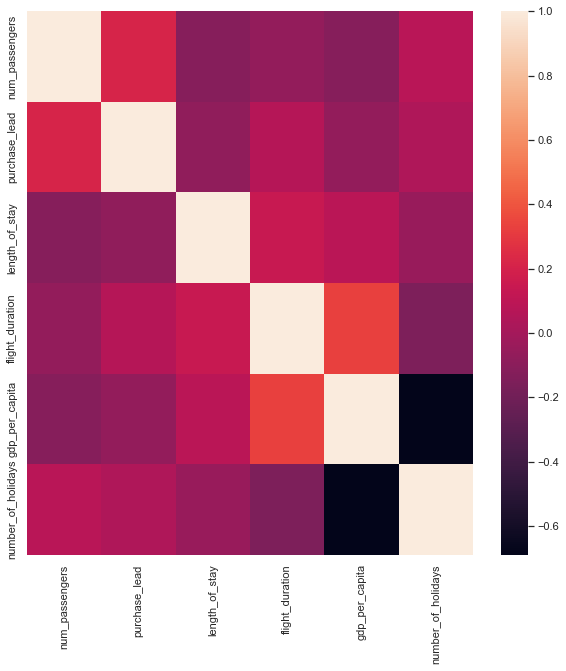

In [33]:
## Create correlation heatmap for numeric columns

sns.set(rc={'figure.figsize':(10, 10)})
sns.heatmap(df_numeric.drop('booking_complete', axis=1).corr())

<AxesSubplot:xlabel='booking_complete', ylabel='count'>

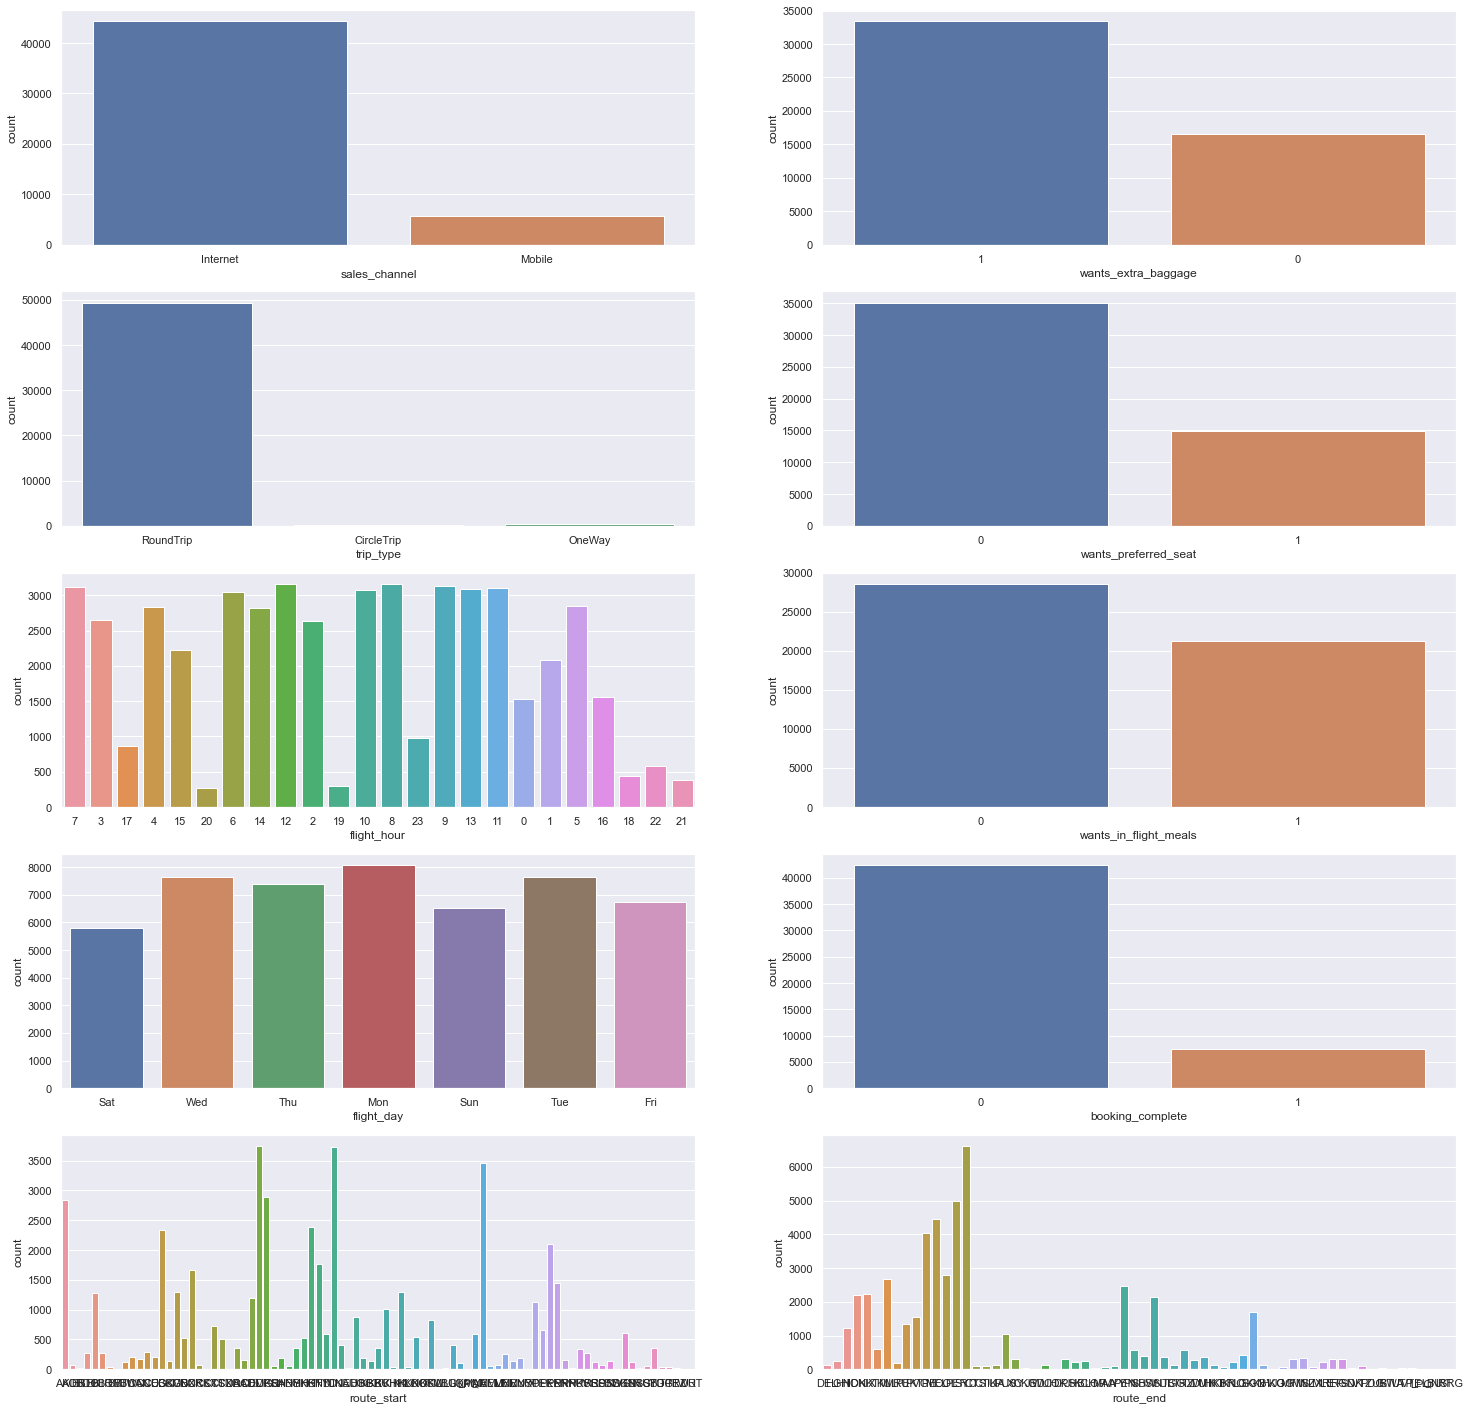

In [34]:
## Create count plots for most categorical columns

fig, axes = plt.subplots(5, 2, figsize=(25, 25))
sns.countplot(ax=axes[0, 0], data=df, x='sales_channel')
sns.countplot(ax=axes[1, 0], data=df, x='trip_type')
sns.countplot(ax=axes[2, 0], data=df, x='flight_hour')
sns.countplot(ax=axes[3, 0], data=df, x='flight_day')
sns.countplot(ax=axes[0, 1], data=df, x='wants_extra_baggage')
sns.countplot(ax=axes[1, 1], data=df, x='wants_preferred_seat')
sns.countplot(ax=axes[2, 1], data=df, x='wants_in_flight_meals')
sns.countplot(ax=axes[4, 0], data=df, x='route_start')
sns.countplot(ax=axes[4, 1], data=df, x='route_end')
sns.countplot(ax=axes[3, 1], data=df, x='booking_complete')


<AxesSubplot:xlabel='booking_complete', ylabel='count'>

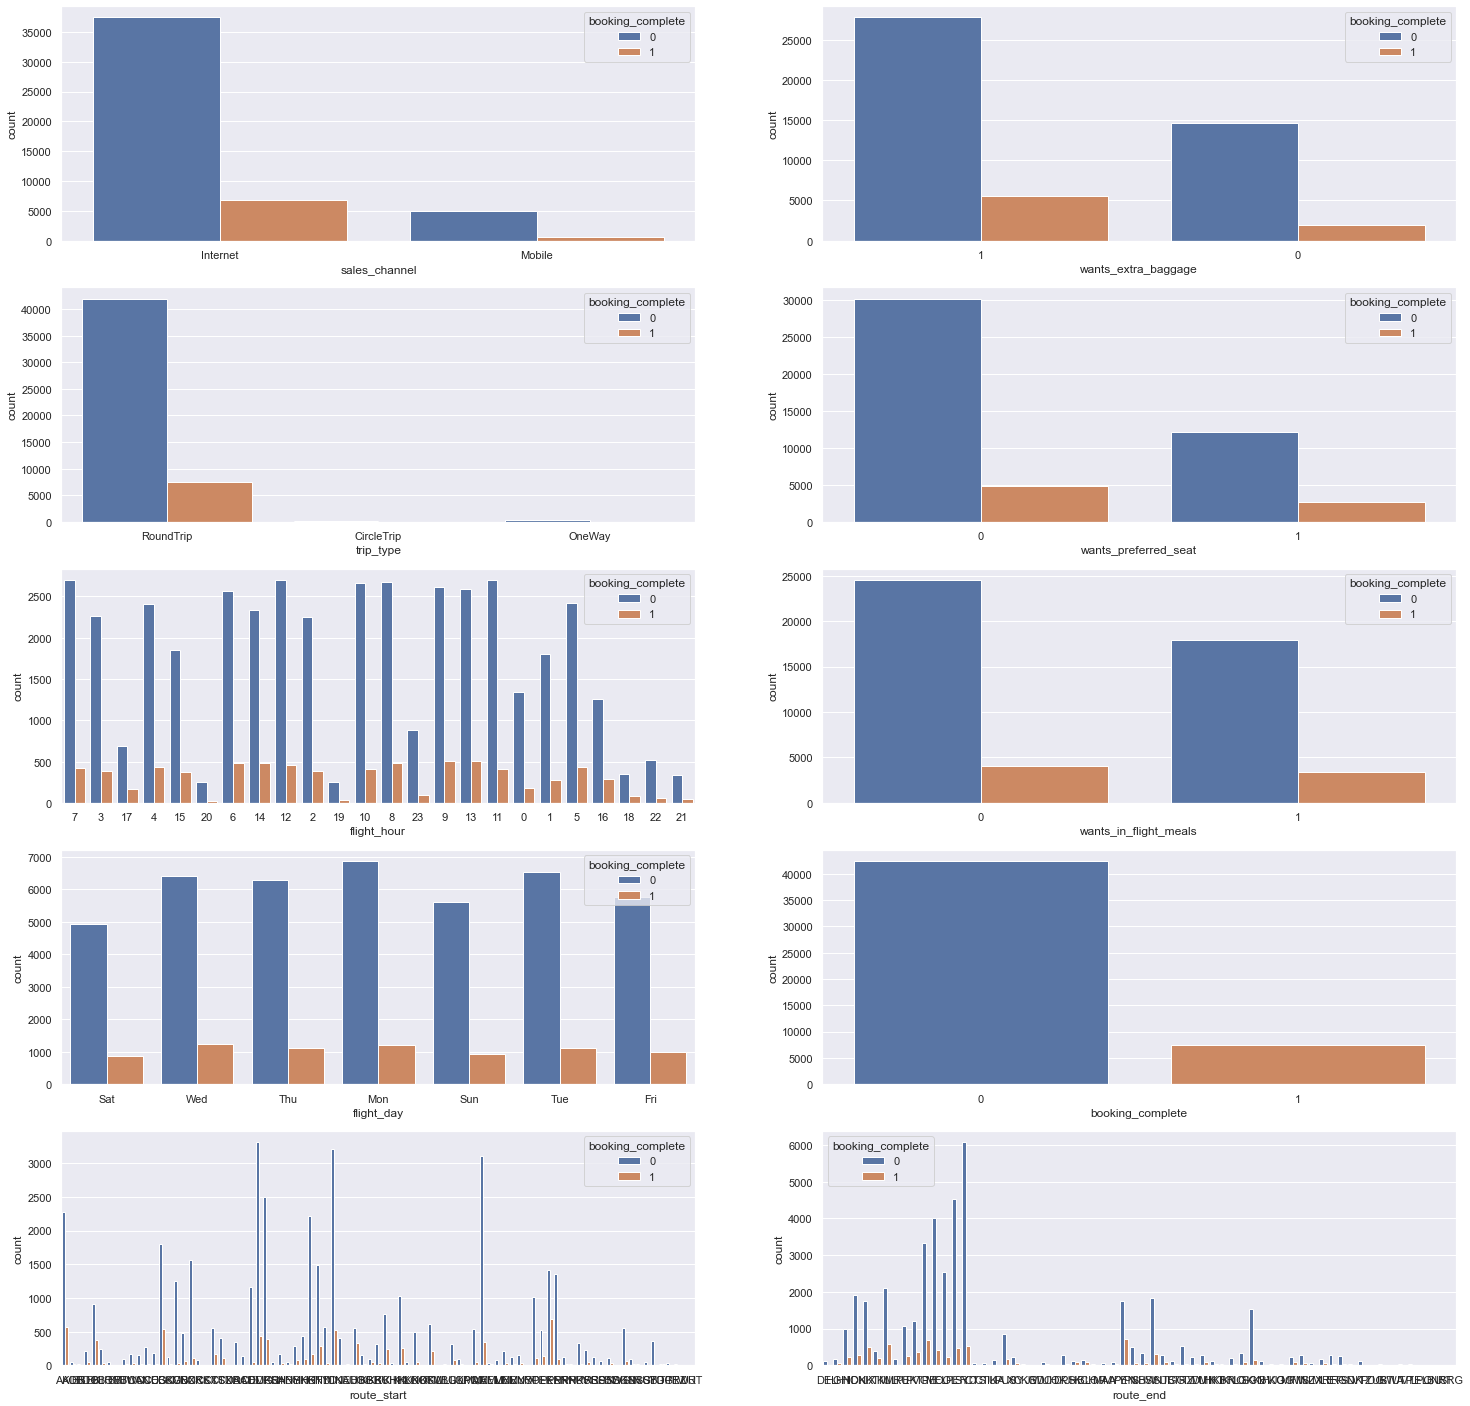

In [35]:
## Create count plots for most categorical columns but with booking status as hue

fig, axes = plt.subplots(5, 2, figsize=(25, 25))
sns.countplot(ax=axes[0, 0], data=df, x='sales_channel', hue='booking_complete')
sns.countplot(ax=axes[1, 0], data=df, x='trip_type', hue='booking_complete')
sns.countplot(ax=axes[2, 0], data=df, x='flight_hour', hue='booking_complete')
sns.countplot(ax=axes[3, 0], data=df, x='flight_day', hue='booking_complete')
sns.countplot(ax=axes[0, 1], data=df, x='wants_extra_baggage', hue='booking_complete')
sns.countplot(ax=axes[1, 1], data=df, x='wants_preferred_seat', hue='booking_complete')
sns.countplot(ax=axes[2, 1], data=df, x='wants_in_flight_meals', hue='booking_complete')
sns.countplot(ax=axes[4, 0], data=df, x='route_start', hue='booking_complete')
sns.countplot(ax=axes[4, 1], data=df, x='route_end', hue='booking_complete')
sns.countplot(ax=axes[3, 1], data=df, x='booking_complete')


In [36]:
# df.info()

In [37]:
categorical_columns = ['sales_channel', 'trip_type', 'flight_hour', 'flight_day',
                       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
                       'wants_in_flight_meals', 'route_start', 'route_end']

print('NUMBER OF UNIQUE VALUES')
for i in categorical_columns:
    
    print(i + ' : ' + str(len(df[i].unique())))

NUMBER OF UNIQUE VALUES
sales_channel : 2
trip_type : 3
flight_hour : 24
flight_day : 7
booking_origin : 98
wants_extra_baggage : 2
wants_preferred_seat : 2
wants_in_flight_meals : 2
route_start : 85
route_end : 64


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49900 entries, 0 to 49899
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49900 non-null  int64  
 1   sales_channel          49900 non-null  object 
 2   trip_type              49900 non-null  object 
 3   purchase_lead          49900 non-null  int32  
 4   length_of_stay         49900 non-null  int64  
 5   flight_hour            49900 non-null  object 
 6   flight_day             49900 non-null  object 
 7   booking_origin         49900 non-null  object 
 8   wants_extra_baggage    49900 non-null  object 
 9   wants_preferred_seat   49900 non-null  object 
 10  wants_in_flight_meals  49900 non-null  object 
 11  flight_duration        49900 non-null  float64
 12  booking_complete       49900 non-null  object 
 13  gdp_per_capita         49900 non-null  float64
 14  number_of_holidays     49900 non-null  float64
 15  ro

In [39]:
## Back up main data frame before it is scaled

df_copy_unscaled = df.copy()

In [40]:
scaler = MinMaxScaler()
to_scale = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_duration', 'gdp_per_capita', 'number_of_holidays']

df[to_scale] = scaler.fit_transform(df[to_scale])
df.sample(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,gdp_per_capita,number_of_holidays,route_start,route_end
11544,0.000,Internet,RoundTrip,0.005767,0.068123,8,Sat,Australia,0,0,1,0.861284,0,0.601927,0.111111,HKG,OOL
16479,0.000,Internet,RoundTrip,0.167243,0.021851,5,Fri,Japan,1,1,1,0.482402,1,0.390206,0.296296,KIX,LOP
22834,0.000,Mobile,RoundTrip,0.051903,0.051414,10,Mon,Australia,1,1,0,0.809524,0,0.601927,0.111111,PEN,SYD
31528,0.125,Internet,RoundTrip,0.066897,0.005141,8,Wed,Taiwan,1,0,1,0.000000,0,0.043328,0.037037,DPS,TPE
19529,0.000,Internet,RoundTrip,0.115340,0.033419,17,Thu,Australia,1,1,1,0.861284,1,0.601927,0.111111,MEL,RGN
12102,0.375,Internet,RoundTrip,0.056517,0.034704,10,Wed,Russia,1,0,0,0.362319,0,0.118493,0.111111,HKT,PEK
48105,0.000,Internet,RoundTrip,0.005767,0.007712,3,Mon,Malaysia,1,0,0,0.000000,0,0.107617,0.407407,KCH,TPE
25279,0.000,Internet,RoundTrip,0.042676,0.082262,10,Thu,Australia,1,0,1,0.809524,0,0.601927,0.111111,SYD,TPE
24317,0.000,Internet,RoundTrip,0.154556,0.061697,10,Thu,Singapore,1,0,0,0.136646,0,0.725680,0.111111,PVG,SIN
37993,0.000,Internet,RoundTrip,0.028835,0.006427,3,Sat,Australia,0,0,0,0.861284,0,0.601927,0.111111,HKG,MEL


## Random Forest

In [41]:
## Replace the string values in categorical columns to numbers

df_rf = df.copy()
df_rf[categorical_columns] = df_rf[categorical_columns].astype('category')

df_rf[categorical_columns] = df_rf[categorical_columns].apply(lambda x: x.cat.codes)
# df_rf.head()

In [42]:
## Split the data for X and Y and training and validation

X = df_rf.drop('booking_complete', axis=1)
y = df_rf['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


In [43]:
## Train the model

# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

## Test the model

# y_pred = rf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy:', accuracy)

In [44]:
## Train the model again but this time with hyperparameter tuning

# rf = RandomForestClassifier()

# param_distributions = {'n_estimators': randint(50, 500),
#                        'max_depth': randint(1, 20)}

## No need to run this again because we already saved the resulting model. This code takes a long time.

# random_search = RandomizedSearchCV(rf, param_distributions = param_distributions, n_iter=10, cv=10)

# random_search = RandomizedSearchCV(rf, param_distributions = param_distributions, n_iter=5, cv=5)

# random_search.fit(X_train, y_train)

In [45]:
## Get the best hyperparameters

# best_rf = random_search.best_estimator_

# print('Best hyperparameters: ', best_rf)

In [46]:
## Get accuracy of the best model

# y_pred = best_rf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='binary', pos_label='1')
# recall = recall_score(y_test, y_pred, average='binary', pos_label='1')
# f1_score = metrics.f1_score(y_test, y_pred, average='binary', pos_label='1')
# roc_auc_score = roc_auc_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 score:', f1_score)
# print('AUC score:', roc_auc_score)

THE BEST RANDOM FOREST MODEL

RandomForestClassifier(max_depth=15, n_estimators=372)

Accuracy: 0.8543086172344689

Precision: 0.5769230769230769

Recall: 0.06089309878213803

F1 score: 0.1101591187270502

AUC score: 0.5265651097298129

In [47]:
## Save best random forest model to pickle

# filename = 'random_forest_model.sav'
# filename2 = 'random_forest_model.pkl'

# pickle.dump(best_rf, open(filename2, 'wb'))


In [48]:
## Create visualization of some of the trees. But we skip this for now because it is taking a long time

# plt.figure(figsize=(80, 40))

# plot_tree(best_rf.estimators_[5], feature_names=X.columns, class_names=['Booking Complete', 'Booking Incomplete'], filled=True)



In [49]:
## Create confusion matrix. I'm disabling it for now because the AUC is still bad.

# y_pred = best_rf.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [50]:
## Discover feature importances. I'm disabling it for now because the AUC is still bad (0,52).

# feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# feature_importances

# sns.barplot(feature_importances.values, feature_importances.index)

In [71]:
## The best random forest model so far is RandomForestClassifier(max_depth=19, n_estimators=341) with scores:
# Accuracy: 0.8556112224448897
# Precision: 0.5598705501618123
# Recall: 0.11705006765899864
# F1 score: 0.1936205931729155
# AUC score: 0.5505269157396381

## XGBOOST

In [119]:
## Process the data so that it is suitable for XGBoost

# df['booking_complete'] = df['booking_complete'].astype(int)

X, y = df.drop('booking_complete', axis=1), df[['booking_complete']]

y_encoded = OrdinalEncoder().fit_transform(y)

categories = X.select_dtypes(exclude=np.number).columns.tolist()

for column in categories:
    X[column] = X[column].astype('category')

## Split data set for training and test

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=12, stratify=y_encoded)

In [88]:
# categories
# X_train
# y_train

In [89]:
## Create classification matrices

dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [90]:
## Training the XGBosst with cross validation.
## This code works but it uses multiclass classification. I'm going to try with binary classification

# params = {'objective':'multi:softprob', 'num_class':2}

# n = 1000

# results = xgb.cv(params, dtrain, num_boost_round=n, nfold=5, metrics=['mlogloss', 'auc', 'merror'])


In [106]:
## Training the XGBoost model with cross validation
## I was stuck here and somehow it magically works
## I found the error. Using the mlogloss and merror metrics causes the code to stuck

params = {'objective':'binary:logistic'}

num_round = 1000

results = xgb.cv(params, dtrain, num_round, nfold=5,
                 metrics={'error', 'auc'}, seed=12,
                 callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

[0]	train-error:0.14871+0.00113	train-auc:0.76281+0.00131	test-error:0.15150+0.00404	test-auc:0.74708+0.00567
[1]	train-error:0.14852+0.00119	train-auc:0.77557+0.00300	test-error:0.14995+0.00393	test-auc:0.75773+0.00619
[2]	train-error:0.14873+0.00085	train-auc:0.78248+0.00207	test-error:0.14955+0.00435	test-auc:0.76275+0.00494
[3]	train-error:0.14871+0.00082	train-auc:0.78648+0.00223	test-error:0.14972+0.00447	test-auc:0.76563+0.00533
[4]	train-error:0.14878+0.00088	train-auc:0.79075+0.00145	test-error:0.14950+0.00434	test-auc:0.76804+0.00473
[5]	train-error:0.14848+0.00087	train-auc:0.79424+0.00183	test-error:0.14917+0.00443	test-auc:0.76975+0.00429
[6]	train-error:0.14852+0.00092	train-auc:0.79726+0.00167	test-error:0.14925+0.00436	test-auc:0.77084+0.00399
[7]	train-error:0.14809+0.00084	train-auc:0.80063+0.00131	test-error:0.14890+0.00411	test-auc:0.77241+0.00419
[8]	train-error:0.14790+0.00100	train-auc:0.80366+0.00131	test-error:0.14882+0.00399	test-auc:0.77331+0.00364
[9]	train-

[74]	train-error:0.11852+0.00129	train-auc:0.89916+0.00168	test-error:0.15210+0.00455	test-auc:0.78122+0.00427
[75]	train-error:0.11824+0.00131	train-auc:0.90025+0.00180	test-error:0.15190+0.00412	test-auc:0.78135+0.00411
[76]	train-error:0.11781+0.00134	train-auc:0.90089+0.00196	test-error:0.15205+0.00401	test-auc:0.78128+0.00418
[77]	train-error:0.11764+0.00133	train-auc:0.90129+0.00199	test-error:0.15213+0.00410	test-auc:0.78108+0.00431
[78]	train-error:0.11698+0.00142	train-auc:0.90220+0.00220	test-error:0.15190+0.00392	test-auc:0.78099+0.00451
[79]	train-error:0.11681+0.00134	train-auc:0.90265+0.00215	test-error:0.15178+0.00402	test-auc:0.78084+0.00450
[80]	train-error:0.11632+0.00134	train-auc:0.90340+0.00203	test-error:0.15180+0.00444	test-auc:0.78060+0.00430
[81]	train-error:0.11571+0.00108	train-auc:0.90417+0.00175	test-error:0.15173+0.00461	test-auc:0.78026+0.00414
[82]	train-error:0.11534+0.00129	train-auc:0.90487+0.00206	test-error:0.15185+0.00457	test-auc:0.78007+0.00414
[

[148]	train-error:0.09215+0.00120	train-auc:0.94118+0.00157	test-error:0.15441+0.00392	test-auc:0.77481+0.00446
[149]	train-error:0.09182+0.00122	train-auc:0.94160+0.00162	test-error:0.15446+0.00381	test-auc:0.77458+0.00440
[150]	train-error:0.09153+0.00124	train-auc:0.94195+0.00163	test-error:0.15426+0.00374	test-auc:0.77442+0.00450
[151]	train-error:0.09140+0.00129	train-auc:0.94230+0.00162	test-error:0.15443+0.00394	test-auc:0.77418+0.00459
[152]	train-error:0.09133+0.00130	train-auc:0.94241+0.00170	test-error:0.15443+0.00391	test-auc:0.77412+0.00464
[153]	train-error:0.09122+0.00130	train-auc:0.94277+0.00158	test-error:0.15468+0.00367	test-auc:0.77382+0.00449
[154]	train-error:0.09090+0.00132	train-auc:0.94309+0.00163	test-error:0.15476+0.00374	test-auc:0.77379+0.00447
[155]	train-error:0.09071+0.00125	train-auc:0.94341+0.00154	test-error:0.15491+0.00350	test-auc:0.77368+0.00452
[156]	train-error:0.09032+0.00119	train-auc:0.94377+0.00151	test-error:0.15473+0.00337	test-auc:0.77348+

[222]	train-error:0.07061+0.00117	train-auc:0.96614+0.00151	test-error:0.15684+0.00332	test-auc:0.76706+0.00474
[223]	train-error:0.07035+0.00113	train-auc:0.96637+0.00137	test-error:0.15686+0.00304	test-auc:0.76697+0.00461
[224]	train-error:0.07010+0.00119	train-auc:0.96672+0.00145	test-error:0.15676+0.00312	test-auc:0.76688+0.00462
[225]	train-error:0.07005+0.00122	train-auc:0.96691+0.00139	test-error:0.15676+0.00306	test-auc:0.76689+0.00459
[226]	train-error:0.06998+0.00121	train-auc:0.96712+0.00136	test-error:0.15686+0.00290	test-auc:0.76675+0.00459
[227]	train-error:0.06961+0.00118	train-auc:0.96734+0.00137	test-error:0.15696+0.00316	test-auc:0.76673+0.00466
[228]	train-error:0.06937+0.00124	train-auc:0.96753+0.00142	test-error:0.15729+0.00352	test-auc:0.76673+0.00458
[229]	train-error:0.06919+0.00122	train-auc:0.96771+0.00130	test-error:0.15731+0.00355	test-auc:0.76662+0.00464
[230]	train-error:0.06911+0.00131	train-auc:0.96792+0.00121	test-error:0.15721+0.00363	test-auc:0.76663+

[296]	train-error:0.05481+0.00161	train-auc:0.97996+0.00151	test-error:0.15839+0.00325	test-auc:0.76134+0.00372
[297]	train-error:0.05472+0.00168	train-auc:0.98000+0.00156	test-error:0.15842+0.00335	test-auc:0.76131+0.00370
[298]	train-error:0.05464+0.00167	train-auc:0.98007+0.00156	test-error:0.15814+0.00340	test-auc:0.76130+0.00375
[299]	train-error:0.05445+0.00173	train-auc:0.98021+0.00161	test-error:0.15827+0.00336	test-auc:0.76131+0.00378
[300]	train-error:0.05435+0.00176	train-auc:0.98027+0.00161	test-error:0.15822+0.00337	test-auc:0.76124+0.00388
[301]	train-error:0.05396+0.00199	train-auc:0.98041+0.00174	test-error:0.15827+0.00325	test-auc:0.76121+0.00392
[302]	train-error:0.05385+0.00217	train-auc:0.98054+0.00180	test-error:0.15842+0.00326	test-auc:0.76108+0.00389
[303]	train-error:0.05384+0.00207	train-auc:0.98069+0.00183	test-error:0.15857+0.00302	test-auc:0.76101+0.00393
[304]	train-error:0.05360+0.00207	train-auc:0.98086+0.00188	test-error:0.15869+0.00320	test-auc:0.76096+

[370]	train-error:0.04178+0.00134	train-auc:0.98874+0.00069	test-error:0.15994+0.00320	test-auc:0.75820+0.00420
[371]	train-error:0.04165+0.00131	train-auc:0.98883+0.00072	test-error:0.15999+0.00313	test-auc:0.75822+0.00436
[372]	train-error:0.04155+0.00118	train-auc:0.98889+0.00069	test-error:0.15982+0.00320	test-auc:0.75811+0.00441
[373]	train-error:0.04150+0.00126	train-auc:0.98894+0.00072	test-error:0.15967+0.00308	test-auc:0.75806+0.00438
[374]	train-error:0.04139+0.00129	train-auc:0.98899+0.00074	test-error:0.15982+0.00298	test-auc:0.75798+0.00434
[375]	train-error:0.04125+0.00128	train-auc:0.98906+0.00077	test-error:0.15992+0.00296	test-auc:0.75793+0.00426
[376]	train-error:0.04122+0.00127	train-auc:0.98908+0.00079	test-error:0.15967+0.00309	test-auc:0.75793+0.00423
[377]	train-error:0.04109+0.00133	train-auc:0.98917+0.00085	test-error:0.15952+0.00296	test-auc:0.75787+0.00414
[378]	train-error:0.04089+0.00115	train-auc:0.98924+0.00080	test-error:0.15977+0.00279	test-auc:0.75782+

[444]	train-error:0.03136+0.00061	train-auc:0.99365+0.00047	test-error:0.16167+0.00361	test-auc:0.75510+0.00506
[445]	train-error:0.03126+0.00074	train-auc:0.99369+0.00049	test-error:0.16170+0.00373	test-auc:0.75502+0.00500
[446]	train-error:0.03121+0.00078	train-auc:0.99372+0.00049	test-error:0.16180+0.00371	test-auc:0.75510+0.00498
[447]	train-error:0.03105+0.00083	train-auc:0.99375+0.00050	test-error:0.16165+0.00369	test-auc:0.75504+0.00497
[448]	train-error:0.03091+0.00079	train-auc:0.99382+0.00049	test-error:0.16187+0.00354	test-auc:0.75508+0.00494
[449]	train-error:0.03080+0.00075	train-auc:0.99390+0.00046	test-error:0.16182+0.00372	test-auc:0.75492+0.00491
[450]	train-error:0.03074+0.00076	train-auc:0.99394+0.00043	test-error:0.16215+0.00352	test-auc:0.75484+0.00489
[451]	train-error:0.03059+0.00081	train-auc:0.99399+0.00047	test-error:0.16212+0.00356	test-auc:0.75490+0.00477
[452]	train-error:0.03053+0.00086	train-auc:0.99402+0.00046	test-error:0.16237+0.00342	test-auc:0.75486+

[518]	train-error:0.02325+0.00102	train-auc:0.99660+0.00041	test-error:0.16210+0.00402	test-auc:0.75243+0.00502
[519]	train-error:0.02298+0.00108	train-auc:0.99664+0.00039	test-error:0.16207+0.00415	test-auc:0.75237+0.00508
[520]	train-error:0.02298+0.00110	train-auc:0.99667+0.00040	test-error:0.16217+0.00403	test-auc:0.75221+0.00531
[521]	train-error:0.02292+0.00111	train-auc:0.99669+0.00041	test-error:0.16230+0.00415	test-auc:0.75215+0.00528
[522]	train-error:0.02285+0.00125	train-auc:0.99671+0.00040	test-error:0.16222+0.00445	test-auc:0.75218+0.00532
[523]	train-error:0.02263+0.00122	train-auc:0.99674+0.00039	test-error:0.16222+0.00448	test-auc:0.75213+0.00527
[524]	train-error:0.02246+0.00134	train-auc:0.99679+0.00040	test-error:0.16258+0.00406	test-auc:0.75221+0.00521
[525]	train-error:0.02229+0.00129	train-auc:0.99684+0.00040	test-error:0.16255+0.00403	test-auc:0.75235+0.00510
[526]	train-error:0.02223+0.00131	train-auc:0.99686+0.00040	test-error:0.16278+0.00391	test-auc:0.75232+

[592]	train-error:0.01722+0.00098	train-auc:0.99818+0.00033	test-error:0.16253+0.00450	test-auc:0.75067+0.00522
[593]	train-error:0.01713+0.00100	train-auc:0.99821+0.00033	test-error:0.16260+0.00424	test-auc:0.75057+0.00520
[594]	train-error:0.01703+0.00101	train-auc:0.99823+0.00034	test-error:0.16283+0.00434	test-auc:0.75062+0.00511
[595]	train-error:0.01698+0.00102	train-auc:0.99825+0.00034	test-error:0.16298+0.00425	test-auc:0.75055+0.00515
[596]	train-error:0.01693+0.00101	train-auc:0.99826+0.00034	test-error:0.16300+0.00440	test-auc:0.75059+0.00523
[597]	train-error:0.01687+0.00087	train-auc:0.99828+0.00031	test-error:0.16285+0.00426	test-auc:0.75057+0.00524
[598]	train-error:0.01677+0.00085	train-auc:0.99831+0.00032	test-error:0.16283+0.00433	test-auc:0.75066+0.00532
[599]	train-error:0.01671+0.00084	train-auc:0.99832+0.00032	test-error:0.16265+0.00428	test-auc:0.75069+0.00520
[600]	train-error:0.01655+0.00087	train-auc:0.99834+0.00032	test-error:0.16270+0.00445	test-auc:0.75068+

[666]	train-error:0.01202+0.00075	train-auc:0.99916+0.00014	test-error:0.16420+0.00375	test-auc:0.74917+0.00497
[667]	train-error:0.01201+0.00076	train-auc:0.99916+0.00013	test-error:0.16438+0.00374	test-auc:0.74914+0.00492
[668]	train-error:0.01196+0.00075	train-auc:0.99917+0.00013	test-error:0.16435+0.00372	test-auc:0.74910+0.00495
[669]	train-error:0.01189+0.00071	train-auc:0.99918+0.00012	test-error:0.16430+0.00380	test-auc:0.74911+0.00497
[670]	train-error:0.01187+0.00070	train-auc:0.99919+0.00012	test-error:0.16433+0.00368	test-auc:0.74907+0.00498
[671]	train-error:0.01182+0.00068	train-auc:0.99919+0.00012	test-error:0.16438+0.00362	test-auc:0.74913+0.00500
[672]	train-error:0.01182+0.00071	train-auc:0.99920+0.00012	test-error:0.16448+0.00362	test-auc:0.74912+0.00496
[673]	train-error:0.01180+0.00071	train-auc:0.99921+0.00012	test-error:0.16463+0.00400	test-auc:0.74906+0.00501
[674]	train-error:0.01178+0.00075	train-auc:0.99921+0.00012	test-error:0.16473+0.00383	test-auc:0.74909+

[740]	train-error:0.00872+0.00069	train-auc:0.99959+0.00007	test-error:0.16488+0.00378	test-auc:0.74814+0.00482
[741]	train-error:0.00865+0.00063	train-auc:0.99960+0.00006	test-error:0.16511+0.00381	test-auc:0.74808+0.00488
[742]	train-error:0.00855+0.00059	train-auc:0.99960+0.00006	test-error:0.16508+0.00389	test-auc:0.74802+0.00491
[743]	train-error:0.00851+0.00057	train-auc:0.99960+0.00006	test-error:0.16501+0.00391	test-auc:0.74804+0.00492
[744]	train-error:0.00844+0.00053	train-auc:0.99961+0.00006	test-error:0.16511+0.00398	test-auc:0.74799+0.00486
[745]	train-error:0.00844+0.00058	train-auc:0.99961+0.00006	test-error:0.16508+0.00401	test-auc:0.74801+0.00484
[746]	train-error:0.00843+0.00055	train-auc:0.99961+0.00006	test-error:0.16508+0.00391	test-auc:0.74805+0.00480
[747]	train-error:0.00839+0.00053	train-auc:0.99962+0.00005	test-error:0.16513+0.00391	test-auc:0.74804+0.00485
[748]	train-error:0.00840+0.00051	train-auc:0.99962+0.00006	test-error:0.16518+0.00371	test-auc:0.74813+

[814]	train-error:0.00622+0.00085	train-auc:0.99981+0.00007	test-error:0.16513+0.00410	test-auc:0.74716+0.00538
[815]	train-error:0.00617+0.00084	train-auc:0.99981+0.00007	test-error:0.16508+0.00414	test-auc:0.74718+0.00535
[816]	train-error:0.00615+0.00083	train-auc:0.99981+0.00007	test-error:0.16506+0.00398	test-auc:0.74721+0.00539
[817]	train-error:0.00612+0.00086	train-auc:0.99981+0.00007	test-error:0.16490+0.00412	test-auc:0.74724+0.00544
[818]	train-error:0.00607+0.00089	train-auc:0.99981+0.00007	test-error:0.16488+0.00404	test-auc:0.74721+0.00547
[819]	train-error:0.00603+0.00091	train-auc:0.99981+0.00008	test-error:0.16511+0.00414	test-auc:0.74716+0.00552
[820]	train-error:0.00604+0.00091	train-auc:0.99981+0.00008	test-error:0.16511+0.00420	test-auc:0.74722+0.00552
[821]	train-error:0.00602+0.00091	train-auc:0.99982+0.00008	test-error:0.16508+0.00432	test-auc:0.74721+0.00556
[822]	train-error:0.00599+0.00094	train-auc:0.99982+0.00008	test-error:0.16536+0.00427	test-auc:0.74720+

[888]	train-error:0.00458+0.00082	train-auc:0.99991+0.00003	test-error:0.16543+0.00404	test-auc:0.74606+0.00510
[889]	train-error:0.00450+0.00079	train-auc:0.99991+0.00003	test-error:0.16516+0.00390	test-auc:0.74611+0.00508
[890]	train-error:0.00448+0.00082	train-auc:0.99991+0.00003	test-error:0.16526+0.00418	test-auc:0.74602+0.00516
[891]	train-error:0.00448+0.00081	train-auc:0.99991+0.00003	test-error:0.16518+0.00402	test-auc:0.74606+0.00529
[892]	train-error:0.00442+0.00079	train-auc:0.99992+0.00003	test-error:0.16493+0.00398	test-auc:0.74605+0.00524
[893]	train-error:0.00440+0.00079	train-auc:0.99992+0.00003	test-error:0.16488+0.00412	test-auc:0.74605+0.00526
[894]	train-error:0.00438+0.00078	train-auc:0.99992+0.00003	test-error:0.16490+0.00421	test-auc:0.74608+0.00519
[895]	train-error:0.00434+0.00079	train-auc:0.99992+0.00003	test-error:0.16495+0.00422	test-auc:0.74610+0.00523
[896]	train-error:0.00426+0.00082	train-auc:0.99992+0.00003	test-error:0.16495+0.00433	test-auc:0.74608+

[962]	train-error:0.00302+0.00077	train-auc:0.99996+0.00001	test-error:0.16538+0.00457	test-auc:0.74556+0.00523
[963]	train-error:0.00299+0.00071	train-auc:0.99996+0.00001	test-error:0.16533+0.00461	test-auc:0.74549+0.00523
[964]	train-error:0.00297+0.00072	train-auc:0.99996+0.00001	test-error:0.16546+0.00457	test-auc:0.74549+0.00532
[965]	train-error:0.00298+0.00073	train-auc:0.99996+0.00001	test-error:0.16528+0.00475	test-auc:0.74549+0.00530
[966]	train-error:0.00299+0.00075	train-auc:0.99996+0.00001	test-error:0.16533+0.00469	test-auc:0.74556+0.00534
[967]	train-error:0.00299+0.00073	train-auc:0.99996+0.00001	test-error:0.16551+0.00470	test-auc:0.74550+0.00533
[968]	train-error:0.00296+0.00073	train-auc:0.99996+0.00001	test-error:0.16541+0.00471	test-auc:0.74549+0.00533
[969]	train-error:0.00296+0.00073	train-auc:0.99996+0.00001	test-error:0.16536+0.00460	test-auc:0.74548+0.00532
[970]	train-error:0.00294+0.00070	train-auc:0.99996+0.00001	test-error:0.16528+0.00467	test-auc:0.74549+

In [112]:
results.keys()

Index(['train-error-mean', 'train-error-std', 'train-auc-mean',
       'train-auc-std', 'test-error-mean', 'test-error-std', 'test-auc-mean',
       'test-auc-std'],
      dtype='object')

In [115]:
print('XGBOOST CROSS VALIDATION RESULTS')
print('Test Error Mean ' + str(results['test-error-mean'].max()))
print('Test Error STD ' + str(results['test-error-std'].max()))
print('Test AUC Mean ' + str(results['test-auc-mean'].max()))
print('Test AUC STD ' + str(results['test-auc-std'].max()))

XGBOOST CROSS VALIDATION RESULTS
Test Error Mean 0.1659569138276553
Test Error STD 0.0052458283220362745
Test AUC Mean 0.7836747958761092
Test AUC STD 0.0061859091168988455


Result of XGBoost Cross Validation

Test Error Mean 0.1659569138276553

Test Error STD 0.0052458283220362745

Test AUC Mean 0.7836747958761092

Test AUC STD 0.0061859091168988455

In [120]:
## Retraining XGBoost on full data

dtrain_all = xgb.DMatrix(X, y, enable_categorical=True)

params = {'objective':'binary:logistic'}

n = 5000

n = 5000

evals = [(dtrain_all, 'train')]

model = xgb.train(params=params, dtrain=dtrain_all, num_boost_round=n, evals=evals, verbose_eval=50, early_stopping_rounds=50)


[0]	train-logloss:0.55193
[50]	train-logloss:0.30905
[100]	train-logloss:0.28169
[150]	train-logloss:0.25940
[200]	train-logloss:0.24001
[250]	train-logloss:0.22326
[300]	train-logloss:0.20688
[350]	train-logloss:0.19255
[400]	train-logloss:0.17935
[450]	train-logloss:0.16836
[500]	train-logloss:0.15872
[550]	train-logloss:0.14867
[600]	train-logloss:0.13721
[650]	train-logloss:0.12781
[700]	train-logloss:0.12031
[750]	train-logloss:0.11212
[800]	train-logloss:0.10669
[850]	train-logloss:0.10115
[900]	train-logloss:0.09457
[950]	train-logloss:0.08900
[1000]	train-logloss:0.08312
[1050]	train-logloss:0.07868
[1100]	train-logloss:0.07458
[1150]	train-logloss:0.06998
[1200]	train-logloss:0.06598
[1250]	train-logloss:0.06235
[1300]	train-logloss:0.05933
[1350]	train-logloss:0.05596
[1400]	train-logloss:0.05272
[1450]	train-logloss:0.05059
[1500]	train-logloss:0.04844
[1550]	train-logloss:0.04582
[1600]	train-logloss:0.04386
[1650]	train-logloss:0.04165
[1700]	train-logloss:0.03992
[1750]	t

In [123]:
filename1 = 'xgboost_model.sav'
filename2 = 'xgboost_model.pkl'

pickle.dump(model, open(filename1, 'wb'))
pickle.dump(model, open(filename2, 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

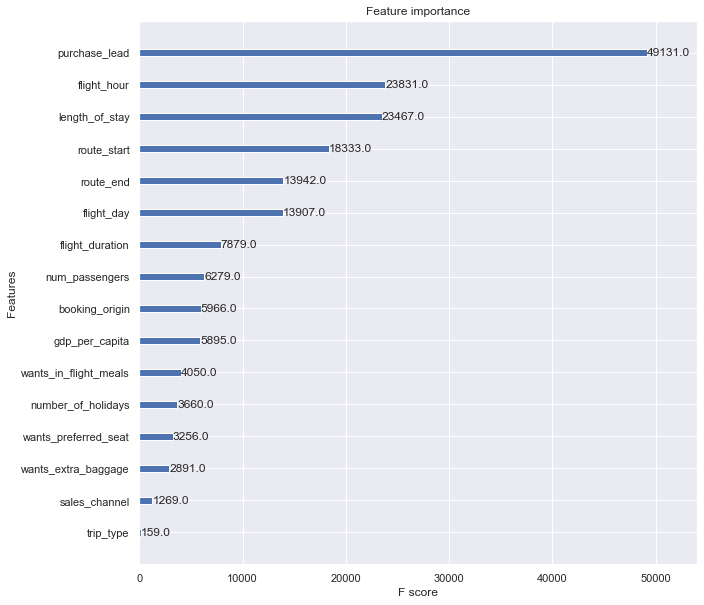

In [160]:
# model.feature_importances_

xgb.plot_importance(model)

In [167]:
model.get_score()

{'num_passengers': 6279.0,
 'sales_channel': 1269.0,
 'trip_type': 159.0,
 'purchase_lead': 49131.0,
 'length_of_stay': 23467.0,
 'flight_hour': 23831.0,
 'flight_day': 13907.0,
 'booking_origin': 5966.0,
 'wants_extra_baggage': 2891.0,
 'wants_preferred_seat': 3256.0,
 'wants_in_flight_meals': 4050.0,
 'flight_duration': 7879.0,
 'gdp_per_capita': 5895.0,
 'number_of_holidays': 3660.0,
 'route_start': 18333.0,
 'route_end': 13942.0}

In [183]:
# bars = xgb_model.get_booster().feature_names
# y_pos = np.arange(len(bars))

df_feature_imp = pd.DataFrame.from_dict(model.get_score(), orient='index').reset_index().rename(columns={'index':'feature', 0:'score'})

In [188]:
df_feature_imp = df_feature_imp.sort_values(by='score', ascending=False)

<AxesSubplot:xlabel='score', ylabel='feature'>

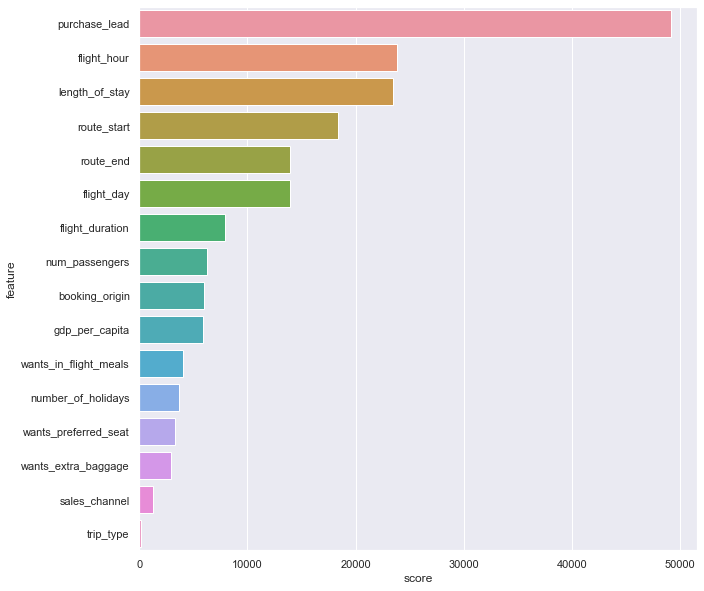

In [189]:
sns.barplot(data=df_feature_imp, x='score', y='feature')

<AxesSubplot:xlabel='purchase_lead', ylabel='Count'>

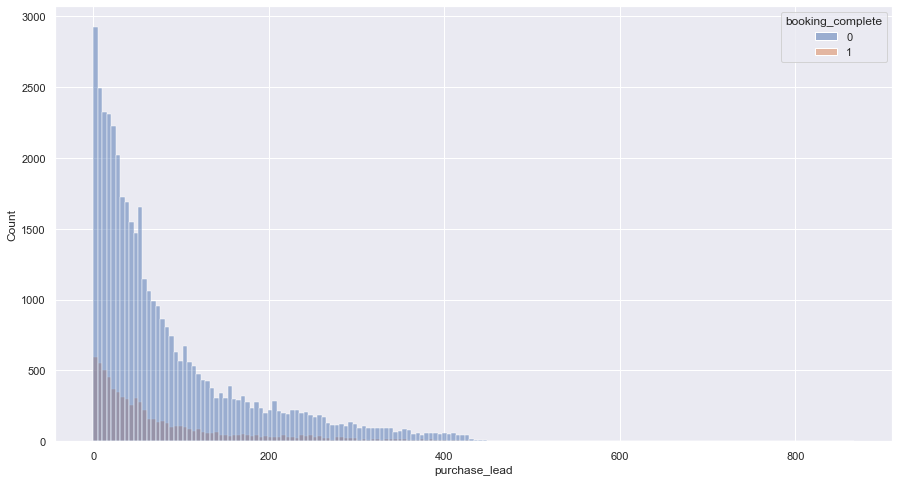

In [193]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.histplot(data=df_copy_unscaled, x='purchase_lead', hue='booking_complete')

<AxesSubplot:xlabel='flight_hour', ylabel='Count'>

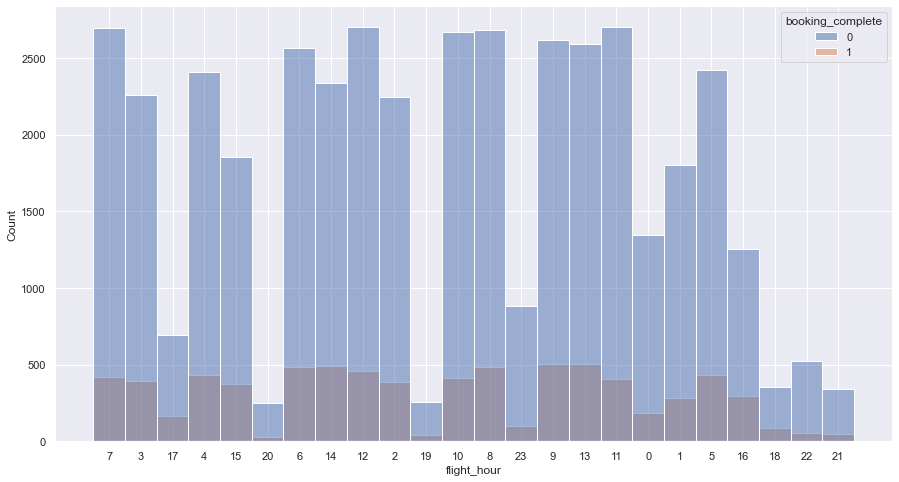

In [194]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.histplot(data=df_copy_unscaled, x='flight_hour', hue='booking_complete')

<AxesSubplot:xlabel='length_of_stay', ylabel='Count'>

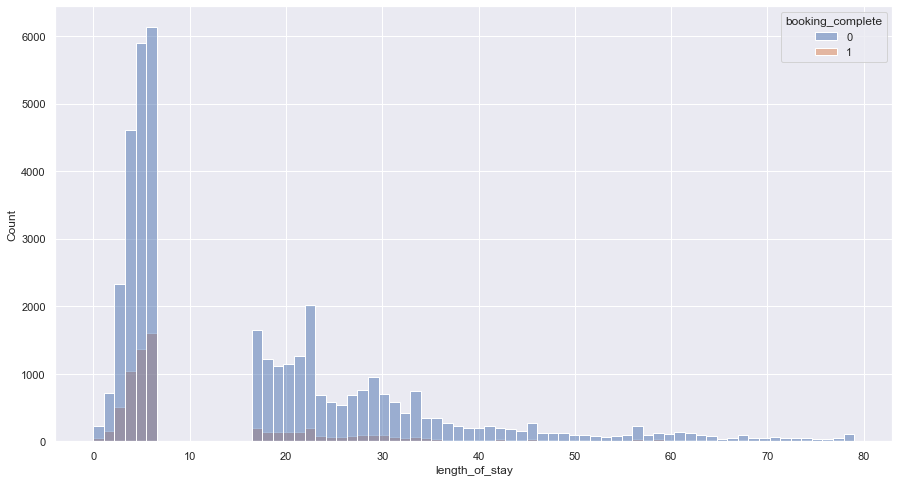

In [199]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.histplot(data=df_copy_unscaled[df_copy_unscaled['length_of_stay'] < 80], x='length_of_stay', hue='booking_complete')

In [205]:
np.sort(df_copy['length_of_stay'].unique())

array([  0,   1,   2,   3,   4,   5,   6,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19

In [211]:
df_route_start = df_copy_unscaled.groupby(['route_start']).count().reset_index().rename(columns={'num_passengers':'count'})[['route_start', 'count']]

df_route_start = df_route_start.sort_values(by='count', ascending=False)

df_route_start.head()

,route_start,count
26,DMK,3742
36,ICN,3730
56,MEL,3460
27,DPS,2882
0,AKL,2841


<AxesSubplot:xlabel='count', ylabel='route_start'>

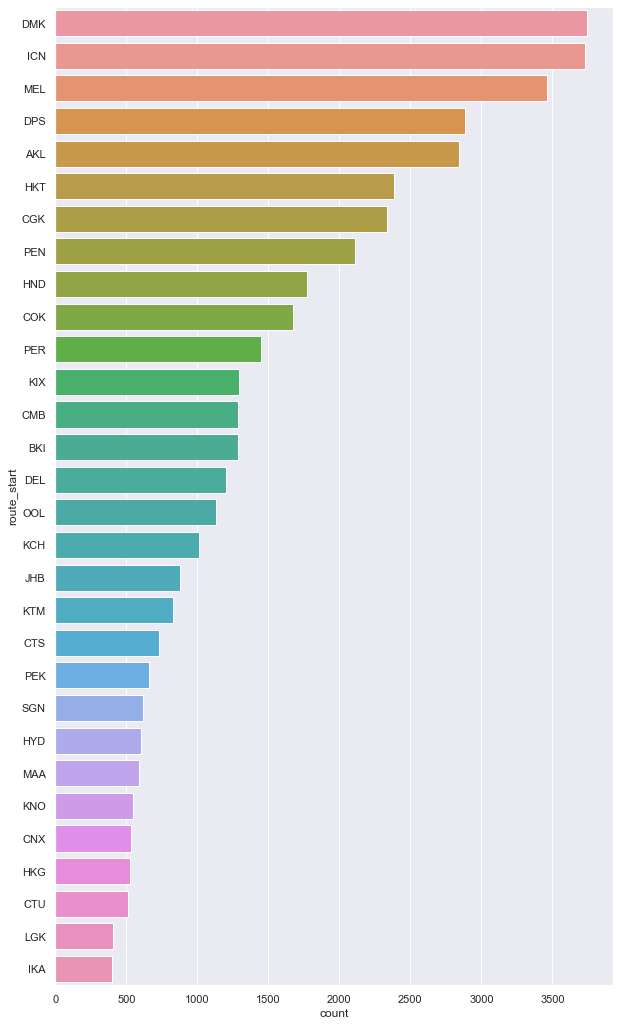

In [217]:
sns.set(rc={'figure.figsize':(10, 18)})
sns.barplot(data=df_route_start.head(30), y='route_start', x='count')